In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import utils as u
import matplotlib.pyplot as plt

# Sampling rate
sr = 16000

# Extract Pitch

In [11]:
# Load audiofile at 16kHz
audiofile = "thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.multitrack-violin-alaapana.mp3"

# Track info
raga, piece, instrument, section = u.process_filename(audiofile)
print("Raga:", raga)
print("Piece:", piece)
print("Instrument:", instrument)
print("Section:", section)

# Load audio
y, sr = u.load_normalize(audiofile, sr = sr)
length_s = len(y) / sr
print("Audio length:", length_s, "s")

Raga: thodi
Piece: Karuna Nidhi Illalo
Instrument: violin
Section: alaapana
Audio length: 305.1639375 s


#### Tonic processing only for violin tracks

In [5]:
# Calculate tonic and save
tonic = u.identify_tonic(y, sr)
print(f"Estimated tonic: {tonic}")
tonic_file = audiofile.replace(".mp3", ".tonic")
np.savetxt(tonic_file, [tonic], fmt="%s")

Estimated tonic: 135.63082885742188


In [13]:
# Load tonic
tonic_file = "thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.multitrack-violin-main.tonic"
tonic = np.loadtxt(tonic_file)
print(f"Loaded tonic: {tonic}")

Loaded tonic: 135.63082885742188


In [14]:
# Apply a high pass filter to the audio signal (tonic - 1)
y_filt = u.high_pass(y, sr, tonic - 1, order = 10)
y_filt = y_filt.astype(np.float32)  

#### Raw pitch extraction

In [15]:
# Calculate raw pitch with melodia
hopsize_ms = 7.5
binResolution = 1
hopSize = u.ms_to_samples(hopsize_ms, sr)
filterIterations = 5

if instrument == "vocal":
    minFrequency = 80
    f0, conf = u.melodia(y, sr, hopSize = hopSize, minFrequency = minFrequency, binResolution = binResolution, filterIterations = filterIterations)
else:
    minFrequency = tonic - 1
    f0, conf = u.melodia(y_filt, sr, hopSize = hopSize, minFrequency = minFrequency, binResolution = binResolution, filterIterations = filterIterations)

In [16]:
# Pitch contour frame rate
framerate = len(f0) / length_s
print(f"Pitch contour frame rate: {framerate}")

Pitch contour frame rate: 133.3381668009183


In [17]:
# Save the pitch contour
pitchfile = audiofile.replace(".mp3", ".pitch")
times = np.linspace(0, length_s, len(f0))
np.savetxt(pitchfile, np.array([times, f0, conf]).T)

# Process Pitch

In [13]:
# Load the pitch contour
pitchfile = "kalyani/Kailasapathe/Kailasapathe.multitrack-violin-solo.pitch"
times, f0, conf = np.loadtxt(pitchfile).T

# Track info
raga, piece, instrument, section = u.process_filename(pitchfile)
print("Raga:", raga)
print("Piece:", piece)
print("Instrument:", instrument)
print("Section:", section)

# Load the tonics
vitonic_path = raga + "/" + piece + "/" + piece + ".multitrack-violin-main.tonic"
votonic_path = raga + "/" + piece + "/" + piece + ".ctonic.txt"
tonic_violin = np.loadtxt(vitonic_path)
tonic_vocal = np.loadtxt(votonic_path)
print("Violin tonic:", tonic_violin, "Hz, Vocal tonic:", tonic_vocal, "Hz")

# Set the tonic based on the instrument
if instrument == "vocal":
    tonic = tonic_vocal
    print("Using vocal tonic")
else:
    tonic = tonic_violin
    print("Using violin tonic")

Raga: kalyani
Piece: Kailasapathe
Instrument: violin
Section: solo
Violin tonic: 176.9892578125 Hz, Vocal tonic: 176.9892578125 Hz
Using violin tonic


In [14]:
# Length of audio in seconds
length_s = times[-1]
print("Length of audio in seconds: {:.2f} s".format(length_s))

# Pitch contour frame rate
frameRate = int(len(f0)/length_s)  
print("Pitch contour frame rate:", frameRate)

# Get voiced segments
voiced_segments = u.voiced_segments(f0)
print("Number of voiced segments:", len(voiced_segments))

Length of audio in seconds: 300.11 s
Pitch contour frame rate: 133
Number of voiced segments: 184


#### Remove low confidence estimations

Selected threshold: 0.0477167047560215


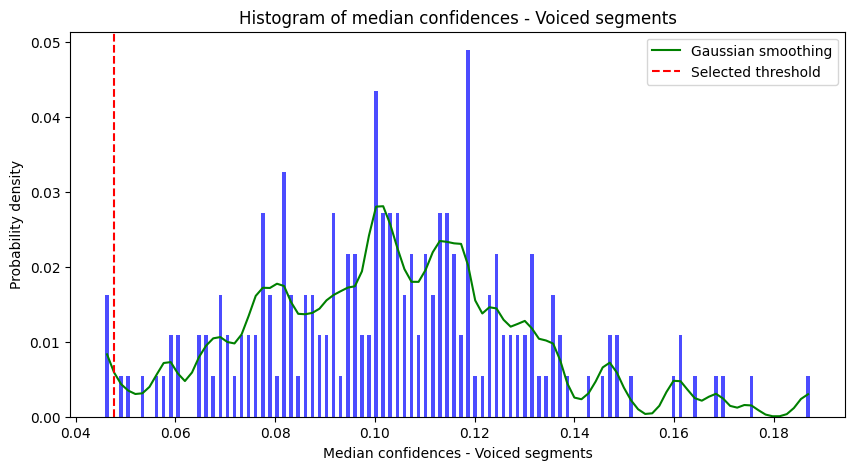

In [15]:
# Removing segments with low confidence estimation
median_conf = u.median_confidences(conf, voiced_segments)
plt.figure(figsize=(10, 5))
hist, bin_edges = np.histogram(median_conf, bins = 100, density = True)
hist = hist/np.sum(hist)
peaks = u.find_minimas(hist, height = 0.015)
gaussian_fit = u.gaussian_filter(hist, 10, sigma = 1.5)
threshold = bin_edges[peaks[0]]
print("Selected threshold:", threshold)
plt.bar(bin_edges[:-1], hist, width = 0.5*(bin_edges[1] - bin_edges[0]), color = 'b', alpha = 0.7)
plt.plot(bin_edges[:-1], gaussian_fit, color = 'g', label = "Gaussian smoothing")
plt.axvline(x = threshold, color = 'r', linestyle = '--', label = "Selected threshold")
plt.xlabel("Median confidences - Voiced segments")
plt.ylabel("Probability density")
plt.title("Histogram of median confidences - Voiced segments")
plt.legend()
plt.show()

In [16]:
# Keeping and discarding segments based on threshold
f0_filt = f0.copy()
f0_disc = f0.copy()
print("Selected threshold: {:.3f}".format(threshold))

# # Manual threshold (if necessary)
# threshold = 0.02

for i in range(len(voiced_segments)):
    if median_conf[i] < threshold:
        start = voiced_segments[i][0]
        end = voiced_segments[i][1] + 1
        f0_filt[start:end] = 0
    if median_conf[i] > threshold:
        start = voiced_segments[i][0]
        end = voiced_segments[i][1] + 1
        f0_disc[start:end] = 0

# Print the number of voices segments in f0_filt, f0_disc and f0
voiced_segments_filt = u.voiced_segments(f0_filt)
voiced_segments_disc = u.voiced_segments(f0_disc)
print("Number of voiced segments in f0_filt:", len(voiced_segments_filt))
print("Number of voiced segments in f0_disc:", len(voiced_segments_disc))
print("Number of voiced segments in f0:", len(voiced_segments))

Selected threshold: 0.048
Number of voiced segments in f0_filt: 181
Number of voiced segments in f0_disc: 3
Number of voiced segments in f0: 184


### Octave estimation errors

Number of octave jumps in f0_filt: 4


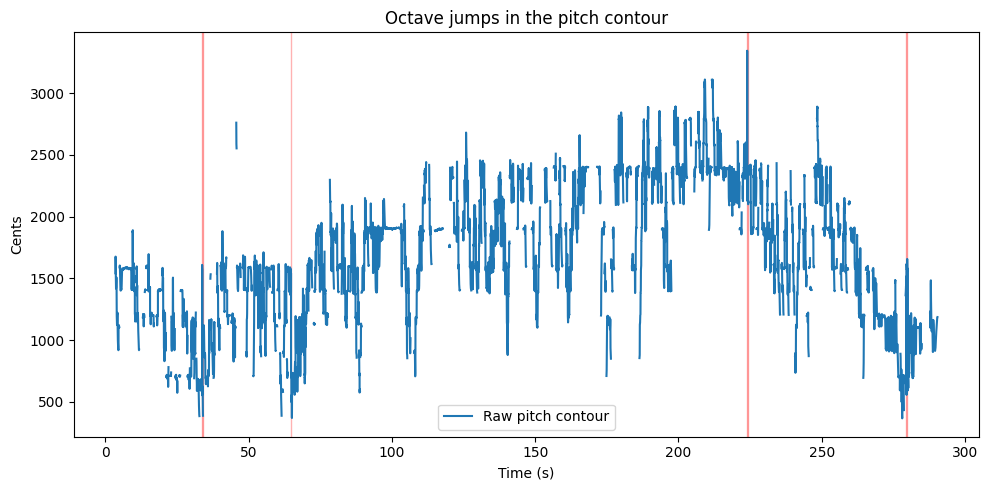

In [17]:
octave_jumps = u.octave_jumps(u.hz_to_cents(f0_filt, tonic), voiced_segments_filt, jump_threshold = 1000)
merged_jumps = u.merge_intervals(octave_jumps)
print("Number of octave jumps in f0_filt:", len(merged_jumps))

plt.figure(figsize=(10, 5))
plt.plot(times, u.hz_to_cents(f0_filt, tonic), label = "Raw pitch contour")
plt.xlabel("Time (s)")
plt.ylabel("Cents")
for jump in merged_jumps:
    plt.axvspan(times[jump[0]], times[jump[1]], color = 'r', alpha = 0.3)
plt.title("Octave jumps in the pitch contour")
plt.legend()
plt.tight_layout()
plt.show()

Number of octave jumps:  4
Number of octave jumps: 2
Number of octave jumps: 2
Number of octave jumps: 1
Number of octave jumps: 1
Number of octave jumps: 1
Number of octave jumps: 1
Number of octave jumps: 1
Number of octave jumps: 1


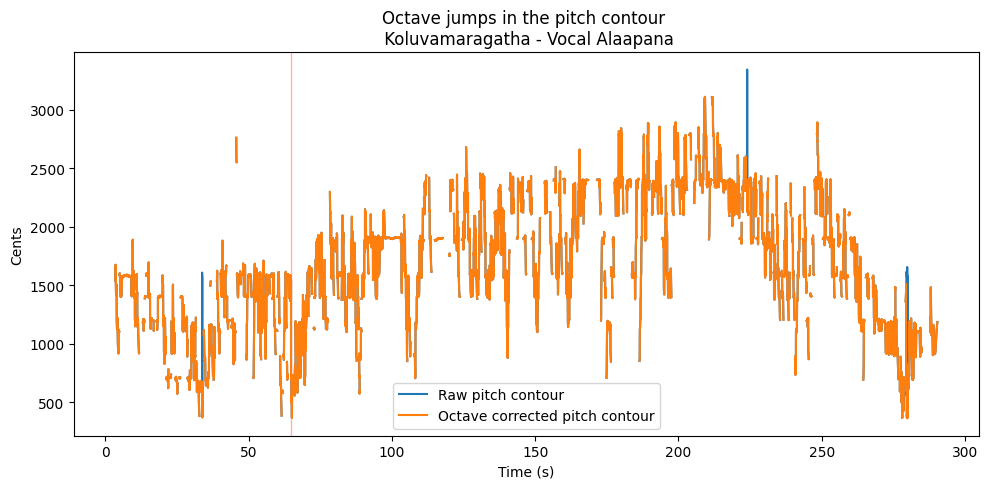

In [18]:
# Correct octave errors
f0_corr = u.correct_octave_jump(u.hz_to_cents(f0_filt, tonic))
f0_corr = u.cents_to_hz(f0_corr, tonic)

# Recalculate the octave jumps
octave_jumps = u.octave_jumps(u.hz_to_cents(f0_corr, tonic), voiced_segments_filt, jump_threshold = 1000)
merged_jumps = u.merge_intervals(octave_jumps)

plt.figure(figsize=(10, 5))
plt.plot(times, u.hz_to_cents(f0_filt, tonic), label = "Raw pitch contour")
plt.plot(times, u.hz_to_cents(f0_corr, tonic), label = "Octave corrected pitch contour")
plt.xlabel("Time (s)")
plt.ylabel("Cents")
for jump in merged_jumps:
    plt.axvspan(times[jump[0]], times[jump[1]], color = 'r', alpha = 0.3)
plt.title("Octave jumps in the pitch contour \n Koluvamaragatha - Vocal Alaapana")
plt.legend()
plt.tight_layout()
plt.show()


#### Smoothing

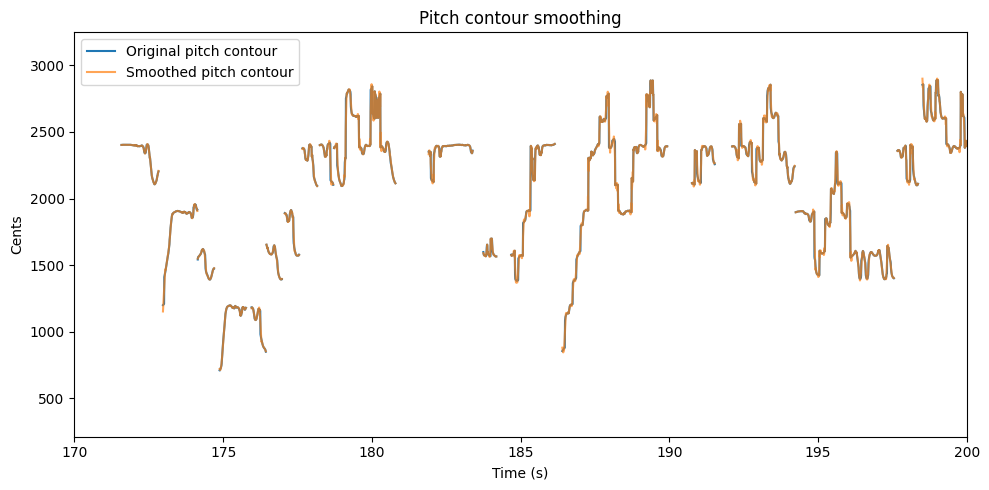

In [21]:
# Pitch contour smoothing and interpolation
window_ms = 100
window_samples = u.ms_to_samples(window_ms, 133)
# Ensure window_samples is odd
if window_samples % 2 == 0:
    window_samples += 1
# Smooth contour
f0_smoothed = u.savitsky_golay_filter(f0_corr, window_samples, 2, peak = True)

plt.figure(figsize=(10, 5))
plt.plot(times, u.hz_to_cents(f0_corr, tonic), label = "Original pitch contour")
plt.plot(times, u.hz_to_cents(f0_smoothed, tonic), label = "Smoothed pitch contour", alpha = 0.7)
plt.xlabel("Time (s)")
plt.ylabel("Cents")
plt.xlim(170, 200)
plt.title("Pitch contour smoothing")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Save processed pitch contour
processedfile = pitchfile.replace(".pitch", "-processed.pitch")
np.savetxt(processedfile, np.array([times, f0_smoothed]).T)